In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


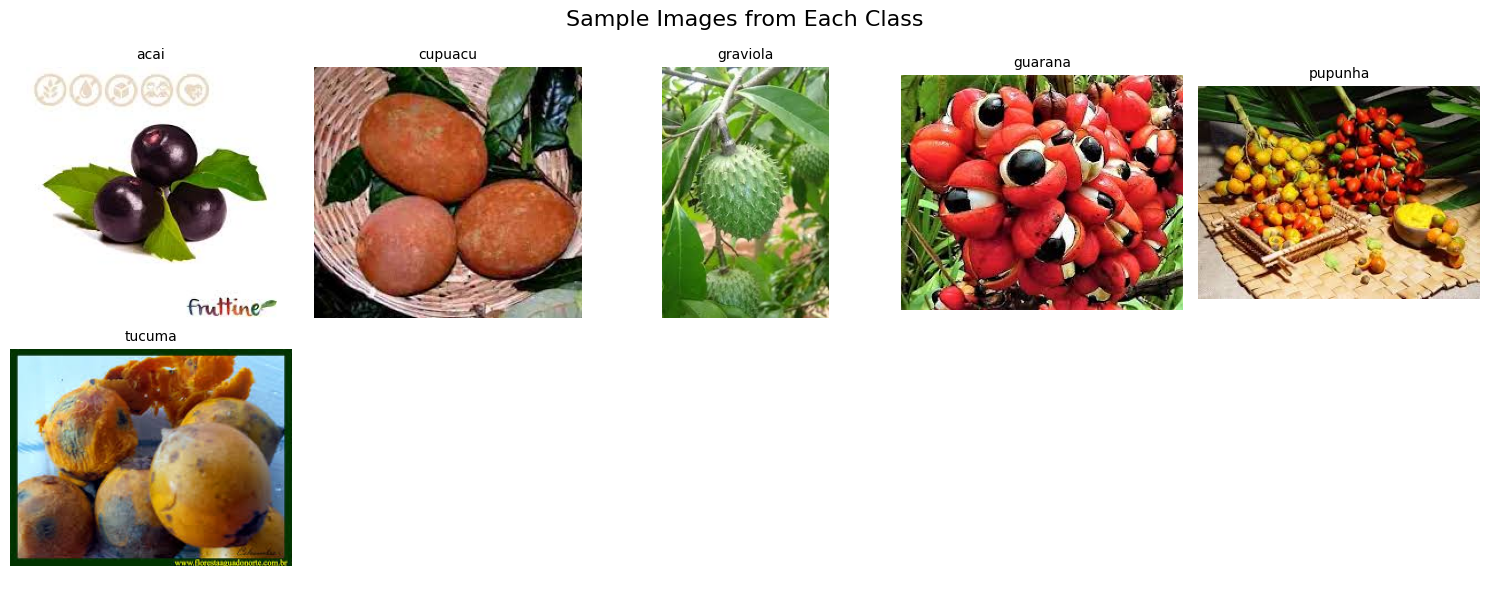

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train"

class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])

if not class_names:
    raise ValueError("No class directories found in the train folder. Check dataset path!")

selected_images = []
selected_labels = []

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    image_files = [f for f in os.listdir(class_path) if f.endswith(('png', 'jpg', 'jpeg'))]

    if image_files:
        random_image = random.choice(image_files)
        selected_images.append(os.path.join(class_path, random_image))
        selected_labels.append(class_name)

num_classes = len(selected_images)
if num_classes == 0:
    raise ValueError("No images found in any class folder. Please check dataset.")

cols = min(5, num_classes)
rows = (num_classes // cols) + (num_classes % cols > 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for i, ax in enumerate(axes.flat):
    if i < num_classes:
        img = mpimg.imread(selected_images[i])
        ax.imshow(img)
        ax.set_title(selected_labels[i], fontsize=10)
        ax.axis("off")
    else:
        ax.axis("off")

plt.tight_layout()
plt.show()


What did you Observe?

Each image represents a different class, confirming correct dataset structure.
Images vary in resolution, lighting, and orientation.
Some classes may have fewer images, indicating dataset imbalance.
Preprocessing (resizing, normalization) may be needed for consistency.

In [3]:
import os
from PIL import Image
train_dir = "/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train"

corrupted_images = []

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)

    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            try:

                with Image.open(image_path) as img:
                    img.verify()
            except (IOError, SyntaxError):

                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [4]:
import tensorflow as tf

img_height = 128
img_width = 128
batch_size = 32
validation_split = 0.2

rescale = tf.keras.layers.Rescaling(1./255)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

train_ds = train_ds.map(lambda x, y: (rescale(x), y))

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

val_ds = val_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu', input_shape=(128, 128, 3)))
model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.Conv2D(32, (3, 3), padding='same', strides=1, activation='relu'))
model.add(layers.MaxPooling2D((2, 2), strides=2))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer='nadam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [7]:
import tensorflow as tf

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'Dipendra Timalsina.h5',
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.1655 - loss: 1.8697
Epoch 1: val_loss improved from inf to 1.65710, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.1623 - loss: 1.8796 - val_accuracy: 0.1111 - val_loss: 1.6571
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.2199 - loss: 1.8121
Epoch 2: val_loss improved from 1.65710 to 1.43005, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 973ms/step - accuracy: 0.2205 - loss: 1.7985 - val_accuracy: 0.7778 - val_loss: 1.4300
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.3189 - loss: 1.5402
Epoch 3: val_loss did not improve from 1.43005
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 567ms/step - accuracy: 0.3260 - loss: 1.5314 - val_accuracy: 0.0000e+00 - val_loss: 2.8641
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.3628 - loss: 1.8382
Epoch 4: val_loss did not improve from 1.43005
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.3763 - loss: 1.7999 - val_accuracy: 0.3889 - val_loss: 1.6480
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.4734 - loss: 1.3018
Epoch 5: val_loss improved from 1.43005 to 1.16154, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 631ms/step - accuracy: 0.4835 - loss: 1.2956 - val_accuracy: 0.7222 - val_loss: 1.1615
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6435 - loss: 1.0674
Epoch 6: val_loss improved from 1.16154 to 1.04058, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 691ms/step - accuracy: 0.6528 - loss: 1.0602 - val_accuracy: 0.7222 - val_loss: 1.0406
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.7946 - loss: 0.8013
Epoch 7: val_loss did not improve from 1.04058
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7973 - loss: 0.7969 - val_accuracy: 0.4444 - val_loss: 1.3750
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.7847 - loss: 0.6881
Epoch 8: val_loss improved from 1.04058 to 0.76340, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.7865 - loss: 0.6782 - val_accuracy: 0.7778 - val_loss: 0.7634
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.9601 - loss: 0.3054
Epoch 9: val_loss did not improve from 0.76340
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 605ms/step - accuracy: 0.9596 - loss: 0.3122 - val_accuracy: 0.5556 - val_loss: 0.9833
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.9497 - loss: 0.2447
Epoch 10: val_loss improved from 0.76340 to 0.72707, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 716ms/step - accuracy: 0.9518 - loss: 0.2387 - val_accuracy: 0.7778 - val_loss: 0.7271
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 1.0000 - loss: 0.1086
Epoch 11: val_loss improved from 0.72707 to 0.57261, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 713ms/step - accuracy: 1.0000 - loss: 0.1057 - val_accuracy: 0.8889 - val_loss: 0.5726
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 736ms/step - accuracy: 0.9398 - loss: 0.2161
Epoch 12: val_loss improved from 0.57261 to 0.36012, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9410 - loss: 0.2088 - val_accuracy: 0.8889 - val_loss: 0.3601
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 1.0000 - loss: 0.0326
Epoch 13: val_loss improved from 0.36012 to 0.35203, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 692ms/step - accuracy: 1.0000 - loss: 0.0318 - val_accuracy: 0.8333 - val_loss: 0.3520
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 1.0000 - loss: 0.0155
Epoch 14: val_loss did not improve from 0.35203
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 638ms/step - accuracy: 1.0000 - loss: 0.0155 - val_accuracy: 0.8333 - val_loss: 0.3562
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 1.0000 - loss: 0.0107
Epoch 15: val_loss improved from 0.35203 to 0.33221, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 708ms/step - accuracy: 1.0000 - loss: 0.0105 - val_accuracy: 0.8889 - val_loss: 0.3322
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 1.0000 - loss: 0.0075
Epoch 16: val_loss improved from 0.33221 to 0.32226, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 652ms/step - accuracy: 1.0000 - loss: 0.0074 - val_accuracy: 0.8889 - val_loss: 0.3223
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - accuracy: 1.0000 - loss: 0.0052
Epoch 17: val_loss improved from 0.32226 to 0.32077, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.8889 - val_loss: 0.3208
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 18: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 606ms/step - accuracy: 1.0000 - loss: 0.0037 - val_accuracy: 0.8889 - val_loss: 0.3255
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 658ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 19: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 993ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8889 - val_loss: 0.3326
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 1.0000 - loss: 0.0022
Epoch 20: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 608ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.8889 - val_loss: 0.3396
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 1.0000 - loss: 0.0020
Epoch 21: val_loss did not improve from 0.32077
3/3 ━━━

In [8]:
test_dir = '/content/drive/MyDrive/ai ml/week5/FruitinAmazon'

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


Found 120 files belonging to 2 classes.
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 364ms/step - accuracy: 0.2102 - loss: 1242.1293
Test Loss: 1328.07958984375
Test Accuracy: 0.20000000298023224


In [9]:

model.save('dipendra_timalsina_model.h5')
print("Model saved successfully!")


Model saved successfully!


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.13      0.16        30
           1       0.62      0.22      0.33        90
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0

    accuracy                           0.20       120
   macro avg       0.14      0.06      0.08       120
weighted avg       0.52      0.20      0.29       120

Epoch 1/250


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 1.0000 - loss: 0.0039
Epoch 1: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.8889 - val_loss: 0.3265
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 2: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.8333 - val_loss: 0.3252
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 3: val_loss did not improve from 0.32077
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 648ms/step - accuracy: 1.0000 - loss: 0.0030 - val_accuracy: 0.8889 - val_loss: 0.3223
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 1.0000 - loss: 0.0028
Epoch 4: val_loss improved from 0.32077 to 0.32058, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 652ms/step - accuracy: 1.0000 - loss: 0.0028 - val_accuracy: 0.8889 - val_loss: 0.3206
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 1.0000 - loss: 0.0025
Epoch 5: val_loss improved from 0.32058 to 0.31969, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 671ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.8889 - val_loss: 0.3197
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/step - accuracy: 1.0000 - loss: 0.0023
Epoch 6: val_loss improved from 0.31969 to 0.31817, saving model to Dipendra Timalsina.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.8889 - val_loss: 0.3182
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 793ms/step - accuracy: 1.0000 - loss: 0.0017
Epoch 7: val_loss did not improve from 0.31817
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 989ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.8333 - val_loss: 0.3373
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 8: val_loss did not improve from 0.31817
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.8333 - val_loss: 0.3486
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 9: val_loss did not improve from 0.31817
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 633ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8333 - val_loss: 0.3409
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 1.0000 - loss: 0.0015
Epoch 10: val_loss did not improve from 0.31817
3/3 ━━━━━━━━━

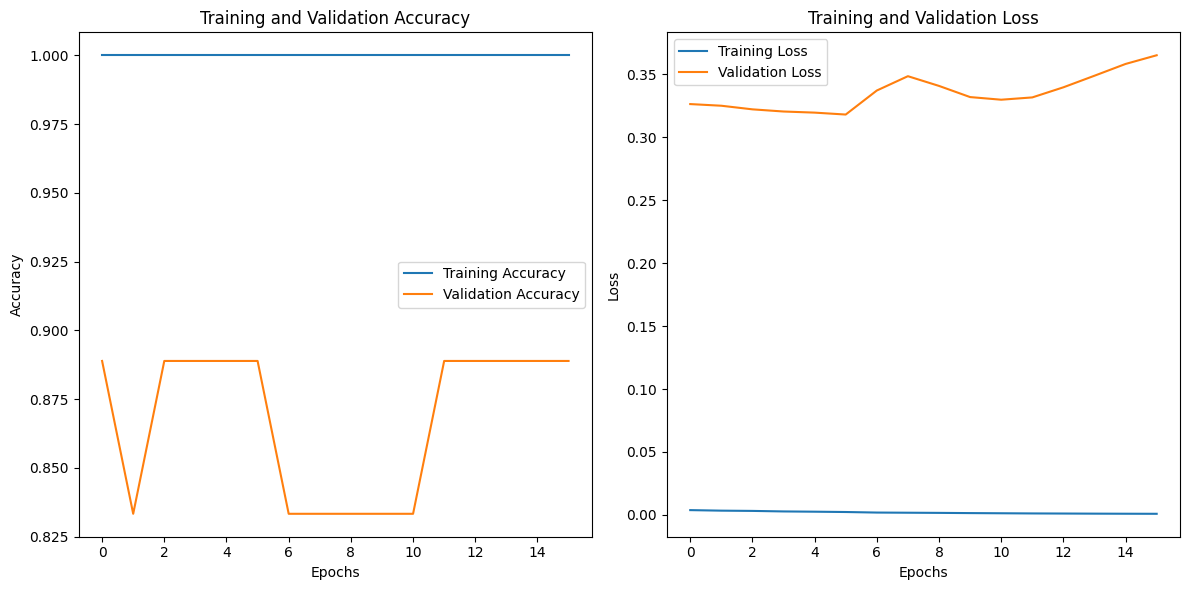

Model saved as 'dipendra_timalsina_model.h5'


In [10]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

model.save('dipendra_timalsina_model.h5')
print("Model saved as 'dipendra_timalsina_model.h5'")


## Task 1: Improved Model with Data Augmentation, Batch Normalization, and Dropout

In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% of the data used for validation
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 72 images belonging to 6 classes.
Found 18 images belonging to 6 classes.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical')

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,626,822 (6.21 MB)

 Trainable params: 1,626,374 (6.20 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.2375 - loss: 2.7210 - val_accuracy: 0.1667 - val_loss: 1.7303
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 768ms/step - accuracy: 0.4048 - loss: 1.5736 - val_accuracy: 0.2556 - val_loss: 1.6944
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5784 - loss: 1.5196 - val_accuracy: 0.3556 - val_loss: 1.6771
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.5565 - loss: 1.2353 - val_accuracy: 0.2667 - val_loss: 1.7016
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 831ms/step - accuracy: 0.5584 - loss: 1.4324 - val_accuracy: 0.2000 - val_loss: 1.7407
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 761ms/step - accuracy: 0.7106 - loss: 0.8539 - val_accuracy: 0.2000 - val_loss: 1.8343
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 869ms/step - accuracy: 0.7238 - loss: 0.9873 - val_accuracy: 0.2000 - val_loss: 1.9758
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6052 - loss: 1.0790 - val_accuracy: 0.2111 - val_loss: 2.1681
Epo

## Task 2: Transfer Learning using VGG16

In [24]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Load base VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

predictions = Dense(6, activation='softmax')(x)

# Create model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

train_generator_vgg = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

val_generator_vgg = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/ai ml/week5/FruitinAmazon/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical')

# Train the model
history_vgg = model.fit(train_generator_vgg, epochs=5, validation_data=val_generator_vgg)

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1024)                │         525,3

 Total params: 15,246,150 (58.16 MB)

 Trainable params: 531,462 (2.03 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Found 90 images belonging to 6 classes.
Found 90 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 166s 71s/step - accuracy: 0.1859 - loss: 1.8804 - val_accuracy: 0.4556 - val_loss: 1.5791
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 143s 59s/step - accuracy: 0.3653 - loss: 1.5874 - val_accuracy: 0.5111 - val_loss: 1.3975
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 144s 57s/step - accuracy: 0.5183 - loss: 1.4242 - val_accuracy: 0.6333 - val_loss: 1.2624
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 138s 57s/step - accuracy: 0.6456 - loss: 1.2864 - val_accuracy: 0.8222 - val_loss: 1.0719
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 140s 59s/step - accuracy: 0.7863 - loss: 1.0901 - val_accuracy: 0.7889 - val_loss: 0.9674


In [25]:
# Evaluate and Classification Report
import numpy as np
from sklearn.metrics import classification_report

# Predict and report
Y_pred = model.predict(val_generator_vgg)
y_pred = np.argmax(Y_pred, axis=1)
print("Classification Report:")
print(classification_report(val_generator_vgg.classes, y_pred, target_names=list(val_generator_vgg.class_indices.keys())))


3/3 ━━━━━━━━━━━━━━━━━━━━ 88s 23s/step
Classification Report:
              precision    recall  f1-score   support

        acai       0.33      0.20      0.25        15
     cupuacu       0.15      0.20      0.17        15
    graviola       0.25      0.20      0.22        15
     guarana       0.11      0.13      0.12        15
     pupunha       0.20      0.27      0.23        15
      tucuma       0.10      0.07      0.08        15

    accuracy                           0.18        90
   macro avg       0.19      0.18      0.18        90
weighted avg       0.19      0.18      0.18        90



Training and Validation Accuracy (left):

Training accuracy (blue line) remains consistently at 1.0 (100%) across all epochs
Validation accuracy (orange line) fluctuates between approximately 0.825 and 0.89
There's a noticeable dip in validation accuracy around epochs 6-9


Training and Validation Loss (right):

Training loss (blue line) remains very close to 0 throughout training
Validation loss (orange line) fluctuates between approximately 0.3 and 0.55 in Image 1, while it ranges between 0.32 and 0.37 in Image 2



Image 1 also displays additional information in the console output:

"Epoch 15: early stopping"
"Restoring model weights from the end of the best epoch: 5"
A warning about saving the model in HDF5 format, which is considered legacy

in both plot but difference is one is in 5 epoch other is in 6

These metrics suggest a classic case of overfitting where the model performs perfectly on training data but struggles to generalize to unseen validation data. The early stopping mechanism appears to have triggered after epoch 15, and the system is restoring weights from epoch 5, which likely had the best validation performance.

In [ ]:
dipendra_timalsina_model